# Training Trainers
### Authors: Nigel Nelson and Collin Quinn
---
## Research Question:
- What features are most predictive of injuries in long distance runners
- Can a injury prediction model be made accurate enough to provide meaningful insight on training protocols
## Hypothesis:
- The greater the perceived exertion an athlete reports, the higher the probability that later training sessions result in injury.
- Training data collected on athletes closer to an injury is more preditive than training data collected in greater advance.

## The Dataset:
- The data set consists of a detailed training log from a Dutch high-level running team over a period of seven years (2012-2019). Included are the middle and long distance runners of the team, that is, those competing on distances between the 800 meters and the marathon. This design decision is motivated by the fact that these groups have strong endurance based components in their training, making their training regimes comparable. The data set contains 42,766 entries from 74 runners, of whom 27 are women and 47 are men. Each entry in the data set corresponds to a single athlete and a week of their training which is comprised of 10 features recorded for 7 days leading up to a potential injury. The 10 daily features are: Number of training sessions, total distance ran, distance ran at low heart rate intensity, distance ran at medium heart rate intensity, distance ran at high heart rate intensity, number of strength training sessions, hours of alternative training (such as cycling or swimming), percieved exertion (how exhausted the athlete at completion of training), percieved training success (how well the athlete felt training went that day), perceived recovery (how recovered the athlete felt before beginning training), and a lastly an injury flag that indicates whether the 7 days of training recorded resulted in in injury that prevented the athlete from completing a training session.
---
## Data Preprocessing:
### Imports:

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

#### Loading the Data Set:
- Discrete features are loaded as categorical features
- Running intensity features are converted to more readable column names for greater interpretability

In [67]:
day_data = pd.read_csv("dataverse_files\day_approach_maskedID_timeseries.csv",
dtype={'nr. sessions': 'category',
'nr. sessions.1': 'category',
'nr. sessions.2': 'category',
'nr. sessions.3': 'category',
'nr. sessions.4': 'category',
'nr. sessions.5': 'category',
'nr. sessions.6': 'category',
'strength training': 'category',
'strength training.1': 'category',
'strength training.2': 'category',
'strength training.3': 'category',
'strength training.4': 'category',
'strength training.5': 'category',
'strength training.6': 'category',
'injury': 'category'})
day_data.head()

for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    km_Z3 = 'km Z3-4' + suffix
    km_Z5 = 'km Z5-T1-T2' + suffix
    km_sprinting = 'km sprinting' + suffix
    low_inten = 'km low-intensity' + suffix
    med_inten = 'km medium-intensity' + suffix
    hgih_inten = 'km high-intensity' + suffix

    day_data.rename(columns = {km_Z3: low_inten,
                            km_Z5: med_inten,
                            km_sprinting: hgih_inten},
                            inplace = True)

In [68]:
day_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   nr. sessions                 42766 non-null  category
 1   total km                     42766 non-null  float64 
 2   km low-intensity             42766 non-null  float64 
 3   km medium-intensity          42766 non-null  float64 
 4   km high-intensity            42766 non-null  float64 
 5   strength training            42766 non-null  category
 6   hours alternative            42766 non-null  float64 
 7   perceived exertion           42766 non-null  float64 
 8   perceived trainingSuccess    42766 non-null  float64 
 9   perceived recovery           42766 non-null  float64 
 10  nr. sessions.1               42766 non-null  category
 11  total km.1                   42766 non-null  float64 
 12  km low-intensity.1           42766 non-null  float64 
 13  k

---
### Data Analysis:
- Each of the features are analyzed using statistical test in order to determine which features have the greatest statistical significance. Continous features are evaluated using the Kruskal Wallis test, while the categorical features are evaluated using chi square contingency test.

In [69]:
pvalues = {}

continuous_features = ['total km', 'km low-intensity', 'km medium-intensity', 'km high-intensity', 'hours alternative',
'perceived exertion', 'perceived trainingSuccess', 'perceived recovery']

categorical_features = ['nr. sessions', 'strength training']

for feature in continuous_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        samples_by_group = []
        for value in set(day_data["injury"]):
            mask = day_data["injury"] == value
            samples_by_group.append(day_data[col][mask])
        stat, p = stats.kruskal(*samples_by_group)
        pvalues[col] = p

for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        combination_counts = day_data.value_counts(subset=["injury", col]).unstack(level=0).fillna(0)
        chi2, p, _, _ = stats.chi2_contingency(combination_counts)
        pvalues[col] = p

### Plotting feature P-values:
- P-values are plotted from least to greatest. In order to control the familywise error rate, a Bonferroni Corrrection is applied to an initial alpha of 0.01 to get a final alpha value of ~0.000143.

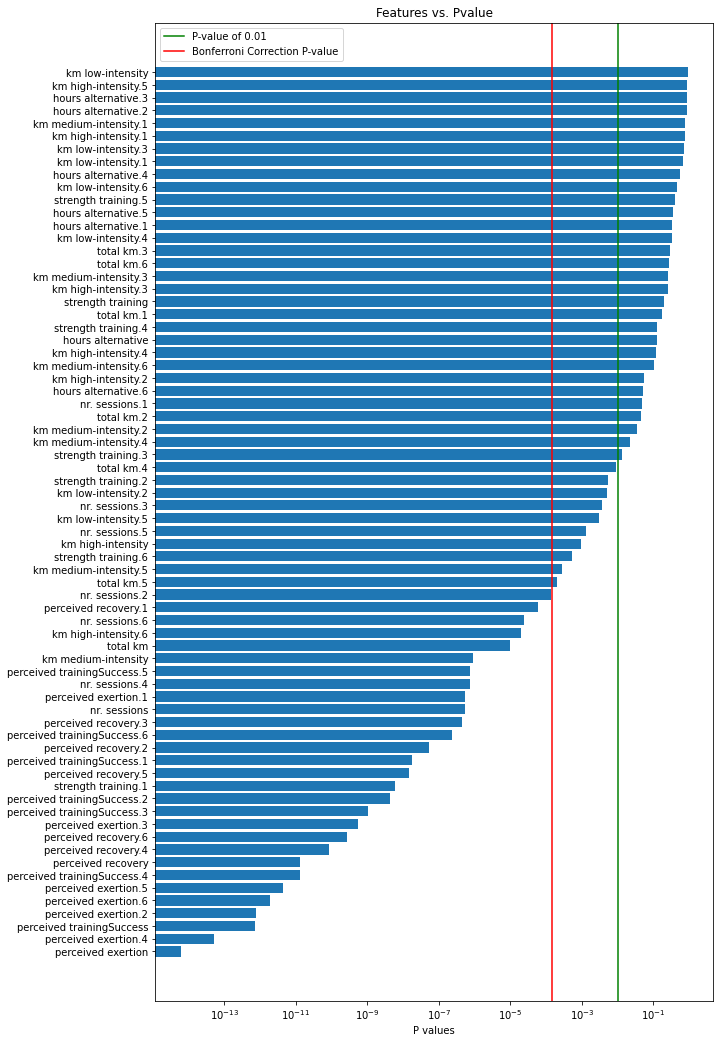

In [70]:
pvalues = dict(sorted(pvalues.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots()

features = pvalues.keys()
y_pos = np.arange(len(features))

ax.barh(y_pos, pvalues.values(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('P values')
ax.set_title('Features vs. Pvalue')
ax.set_xscale('log')
fig.set_size_inches(10, 18)

plt.axvline(x=0.01, c='g', label="P-value of 0.01")
plt.axvline(x=0.01/70, c='r', label="Bonferroni Correction P-value")
plt.legend()

### Applying Bonferroni Correction
- The Bonferroni correction method was chosen to control the familywise error rate.

In [71]:
stat_sig_features = []
for feat, pvalue in pvalues.items():
    if pvalue < .01/70:
        stat_sig_features.append(feat)


sig_features = day_data[stat_sig_features]



---
### Plotting the most predictive features:

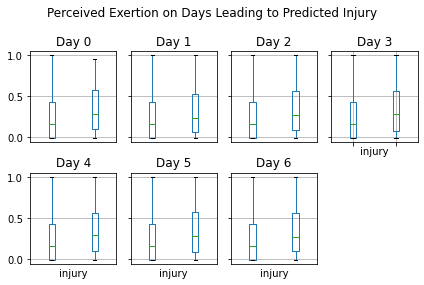

In [72]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived exertion" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('Perceived Exertion on Days Leading to Predicted Injury')
plt.tight_layout()

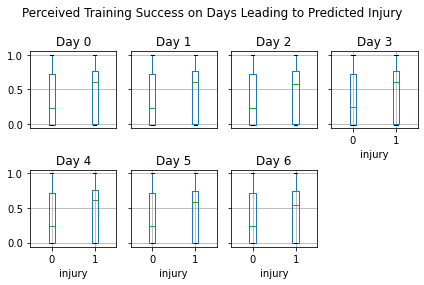

In [73]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived trainingSuccess" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Training Success on Days Leading to Predicted Injury')
plt.tight_layout()

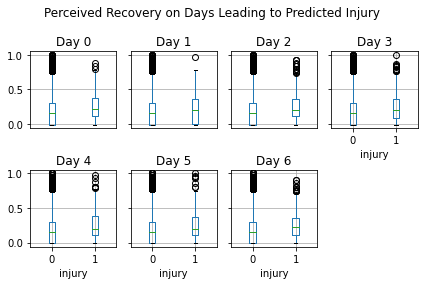

In [74]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived recovery" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Recovery on Days Leading to Predicted Injury')
plt.tight_layout()

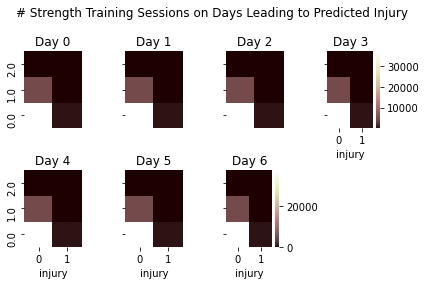

In [75]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "strength training" + suffix
    injury_strength_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Strength Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

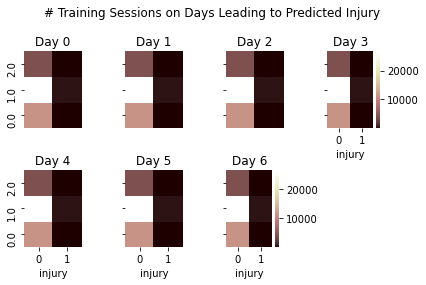

In [76]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "nr. sessions" + suffix
    injury_session_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

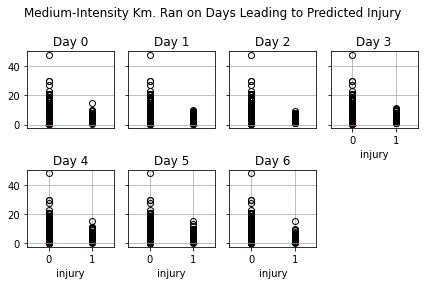

In [77]:

fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "km medium-intensity" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Medium-Intensity Km. Ran on Days Leading to Predicted Injury')
plt.tight_layout()


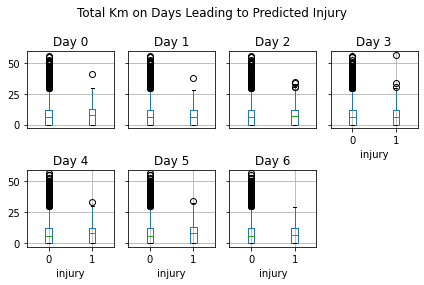

In [78]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "total km" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Total Km on Days Leading to Predicted Injury')
plt.tight_layout()


---
### Using SVD to plot the two most predictive Components:

In [79]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sig_features)

In [80]:
svd = TruncatedSVD(n_components=10, random_state=17)
svd_matrix = svd.fit_transform(scaled_features)
svd_matrix.shape

(42766, 10)

Text(0.5, 1.0, '% data explained vs. Component Index #')

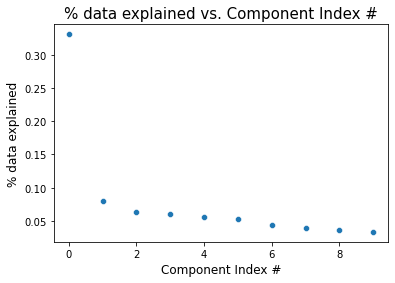

In [81]:
sns.scatterplot(x=range(0,10), y=svd.explained_variance_ratio_)
plt.ylabel('% data explained', fontsize=12)
plt.xlabel('Component Index #', fontsize=12)
plt.title('% data explained vs. Component Index #', fontsize=15)

Text(0.5, 1.0, '2nd vs. 1st Highest Explained Variance Components')

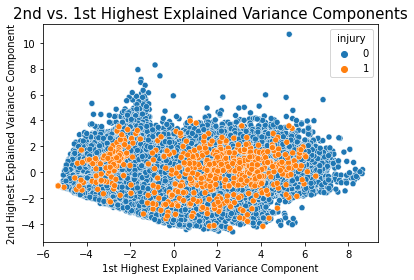

In [82]:
sns.scatterplot(x=svd_matrix[:,0], y=svd_matrix[:,1], hue=day_data['injury'])
plt.ylabel('2nd Highest Explained Variance Component', fontsize=10)
plt.xlabel('1st Highest Explained Variance Component', fontsize=10)
plt.title('2nd vs. 1st Highest Explained Variance Components', fontsize=15)

In [90]:
suffixes = ["", ".1", ".2", ".3", ".4", ".5", ".6"]
categorical_features = []
numeric_features = []


numeric_names = ["perceived recovery", "perceived trainingSuccess", "perceived exertion", "hours alternative", "km high-intensity", "km medium-intensity", "km low-intensity", "total km"]
categorical_names = ["nr. sessions", "strength training"]

for suffix in suffixes:
    for val in numeric_names:
        new_val = val + suffix
        numeric_features.append(new_val)

for suffix in suffixes:
    for val in categorical_names:
        new_val = val + suffix
        categorical_features.append(new_val)

# print(numeric_features)
# print(categorical_features)

for col_name in categorical_features:
    day_data[col_name] = day_data[col_name].astype("category")

In [91]:
features = day_data.copy()
features = features.drop(columns=["injury"])
response = day_data["injury"]

In [92]:
# Random sampling with stratification
df_train, df_test = train_test_split(day_data, stratify=day_data["injury"],random_state=42)
y_train = df_train["injury"]
y_test = df_test["injury"]
X_train = df_train.drop(columns='injury')
X_test = df_test.drop(columns='injury')

In [93]:
numeric_transformer = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [94]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.986


C:\Users\quinnc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
pipe_lr = Pipeline([("preprocessor", preprocessor),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([("preprocessor", preprocessor),
			('pca', PCA(n_components=10)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([("preprocessor", preprocessor),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([("preprocessor", preprocessor),
	    	('pca', PCA(n_components=10)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([("preprocessor", preprocessor),
			('clf', SVC(random_state=42))])

pipe_svm_pca = Pipeline([("preprocessor", preprocessor),
			('pca', PCA(n_components=10)),
			('clf', SVC(random_state=42))])

In [97]:
param_range = []
for x in range(1, 57): # param range of 1 through 56
	param_range.append(x)

param_range_fl = [1.0, 0.5, 0.1]
param_range_tree = [2, 4, 5]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range_tree,
		'clf__max_depth': param_range_tree,
		'clf__min_samples_split': param_range_tree}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


In [99]:
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=5) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=5)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=5, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=5, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs)

In [100]:
# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

In [101]:
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.986
Test set accuracy score for best params: 0.986 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.986
Test set accuracy score for best params: 0.986 

Estimator: Random Forest
